### Load the WSEAD dataset

In [10]:
import os
import pickle
import matplotlib.pyplot as plt
from scipy.stats import mode

# Get path to WESAD folder
current_directory = os.getcwd()
folder_name = "data/WESAD"
folder_path = os.path.join(current_directory, folder_name)

# Make sure it exists
if not (os.path.exists(folder_path) and os.path.isdir(folder_path)):
    print(f"The folder '{folder_name}' does not exist in the current directory.")
else:
    # List everything in the folder just to make sure
    print("Contents of folder:", folder_name)
    for item in os.listdir(folder_path):
        print(item)

Contents of folder: data/WESAD
S5
S2
S3
S4
.DS_Store
S17
S10
S11
S16
S8
S6
S7
S9
S13
S14
S15
wesad_readme.pdf


### For each subject, get the synchronized data in SX.pkl, one file per subject. 

The double-tap signal pattern was used to manually synchronise the two devices’ raw data. This file is a dictionary, with the following
keys:
- ‘subject’: SX, the subject ID
- ‘signal’: includes all the raw data, in two fields:
    - ‘chest’: RespiBAN data (all the modalities: ACC, ECG, EDA, EMG, RESP, TEMP)
    - ‘wrist’: Empatica E4 data (all the modalities: ACC, BVP, EDA, TEMP)
- ‘label’: ID of the respective study protocol condition, sampled at 700 Hz. The following IDs are provided: 0 = not defined / transient, 1 = baseline, 2 = stress, 3 = amusement, 4 = meditation, 5/6/7 = should be ignored in this dataset

In [2]:
valid_subjects = [2,3,4,5,6,7,8,9,10,11,13,14,15,16,17]
subject_num = 2

# The path to the pickle file for this subject
pickle_file_path = f"data/WESAD/S{subject_num}/S{subject_num}.pkl"

try:
    # Open the pickle file in read-binary mode and load the data
    with open(pickle_file_path, "rb") as f:
        loaded_data = pickle.load(f, encoding='latin1')
    
    print(f"Data loaded successfully from the pickle file for Subject {subject_num}:")
    for field in loaded_data:
        print(field)

except FileNotFoundError:
    print("The specified pickle file does not exist.")
except Exception as e:
    print("An error occurred while loading data from the pickle file:", e)

Data loaded successfully from the pickle file for Subject 2:
signal
label
subject


### Functions are defined here for now

In [24]:
def segment_data(data, sampling_rate=700, segment_length=2, window_stride=0.25):
    """
    Segment the given data array into 2-second segments with a sliding window of 0.25 seconds.
    
    Args:
    - data: The data array.
    - sampling_rate: The sampling rate of the data in Hz (default: 700 Hz).
    - segment_length: The length of each segment in seconds (default: 2 seconds).
    - window_stride: The stride of the sliding window in seconds (default: 0.25 seconds).
    
    Returns:
    - segments: A list of segmented data arrays.
    """
    
    segments = []
    start_index = 0
    end_index = int(segment_length * sampling_rate)
    window_stride_samples = int(window_stride * sampling_rate)
    
    while end_index <= len(data):
        segments.append(data[start_index:end_index])
        start_index += window_stride_samples
        end_index += window_stride_samples
    
    return segments


def segment_labels(labels, sampling_rate=700, segment_length=2, window_stride=0.25):
    """
    Segment the labels into 2-second segments with a sliding window of 0.25 seconds.
    
    Args:
    - labels: The labels array.
    - sampling_rate: The sampling rate of the data in Hz (default: 700 Hz).
    - segment_length: The length of each segment in seconds (default: 2 seconds).
    - window_stride: The stride of the sliding window in seconds (default: 0.25 seconds).
    
    Returns:
    - seg_labels: A list containing the majority label for each segment.
    - label_fractions: A list indicating what fraction of the segment the label 
    applies to (maybe useful if a label boundary falls in the middle of the segment)
    """

    seg_labels = []
    label_fractions = []
    start_index = 0
    end_index = int(segment_length * sampling_rate)
    window_stride_samples = int(window_stride * sampling_rate)
    
    while end_index <= len(data):
        seg_label, label_count = mode(labels[start_index:end_index])
        seg_labels.append(seg_label)
        label_fractions.append(label_count/(end_index-start_index))
        start_index += window_stride_samples
        end_index += window_stride_samples
    
    return seg_labels, label_fractions

### Segment the data and make some plots

Chest data is at 700Hz

Labels (the ID of the respective study protocol condition)
- 0 = not defined / transient
- 1 = baseline
- 2 = stress
- 3 = amusement
- 4 = meditation
- 5/6/7 = should be ignored in this dataset

In [48]:
chest_data_types = ["ACC", "ECG", "EDA", "EMG", "Resp", "Temp"]
chest_data = loaded_data["signal"]["chest"]
raw_labels = loaded_data["label"]
segmented_data_dict = {}

segment_length = 2 # in seconds
window_stride = 2 # in seconds (segment_length = window_stride means no overlap between windows)

# Segment the data
for data_type in chest_data_types:
    data = chest_data[data_type] 
    segments = segment_data(data, 700, segment_length, window_stride)
    segmented_data_dict[data_type] = segments

# Segment the labels
seg_labels, label_fracs = segment_labels(raw_labels, 700, segment_length, window_stride)
segmented_data_dict["labels"] = seg_labels
segmented_data_dict["label_fracs"] = label_fracs

<class 'numpy.ndarray'>


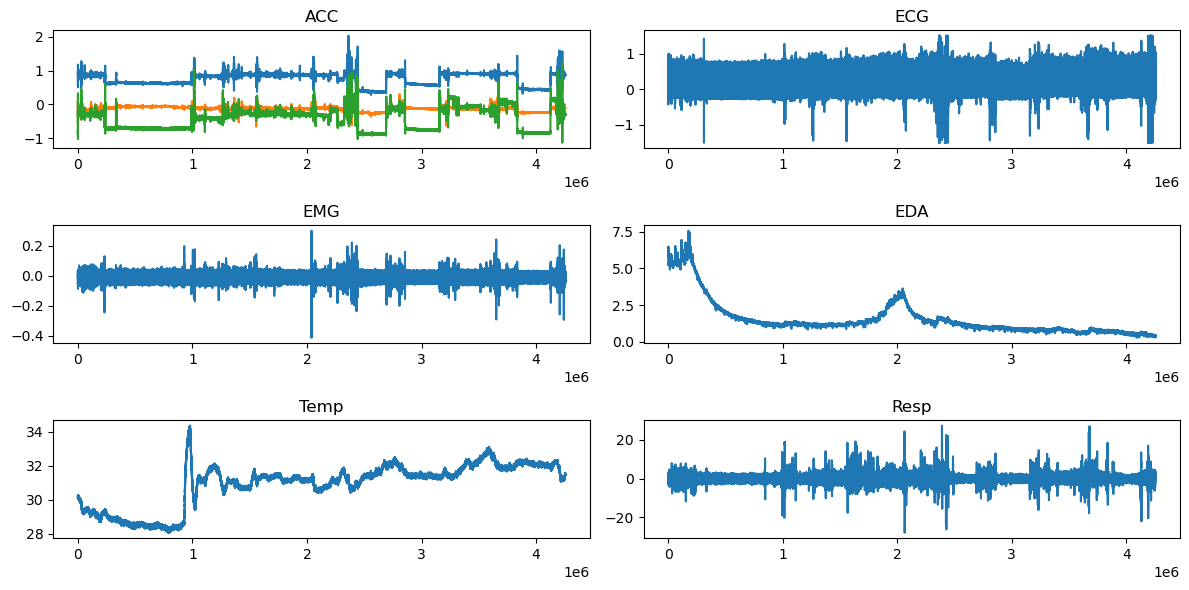

In [54]:
# Make some plots of raw data (sanity check)

fig, axs = plt.subplots(3, 2, figsize=(12, 6))
for i, key in enumerate(chest_data.keys()):
    row_index = i // 2
    col_index = i % 2
    ax = axs[row_index, col_index]
    ax.plot(chest_data[key])
    ax.set_title(key)

plt.tight_layout()
plt.show()

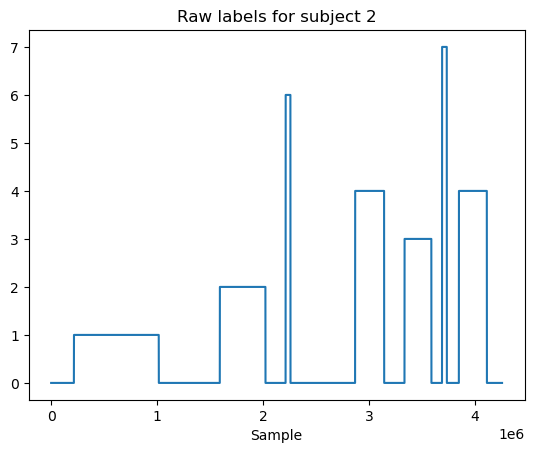

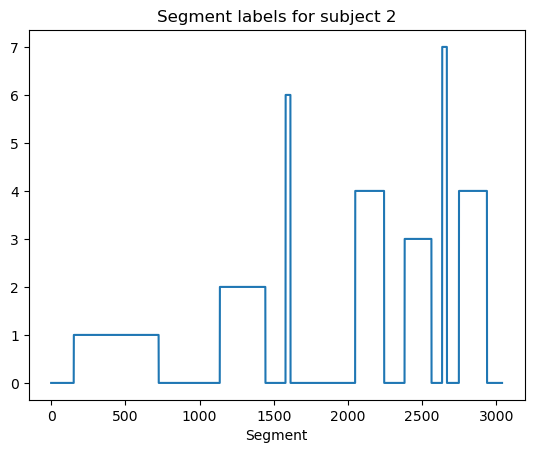

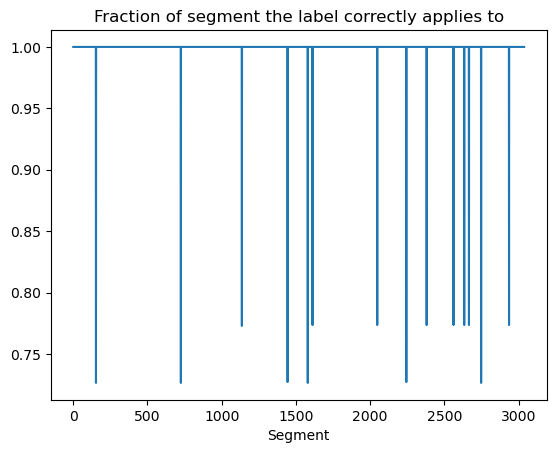

In [37]:
# Make some plots of labels (sanity check for label segmentation)
plt.plot(raw_labels)
plt.title(f"Raw labels for subject {subject_num}")
plt.xlabel("Sample")
plt.show()

plt.plot(seg_labels)
plt.title(f"Segment labels for subject {subject_num}")
plt.xlabel("Segment")
plt.show()

plt.plot(label_fracs)
plt.title(f"Fraction of segment the label correctly applies to")
plt.xlabel("Segment")
plt.show()

In [77]:
# Sanity check
for field in segmented_data:
    print(field)
    print(len(segmented_data[field]))

ACC
3039
ECG
3039
EDA
3039
EMG
3039
Resp
3039
Temp
3039
labels
3039
label_fracs
3039


()

### Feature Extraction
Using the featues detailed in the "Introducing WESAD" paper

3039


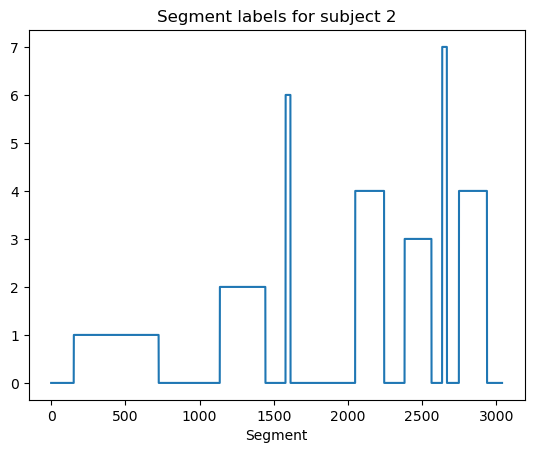

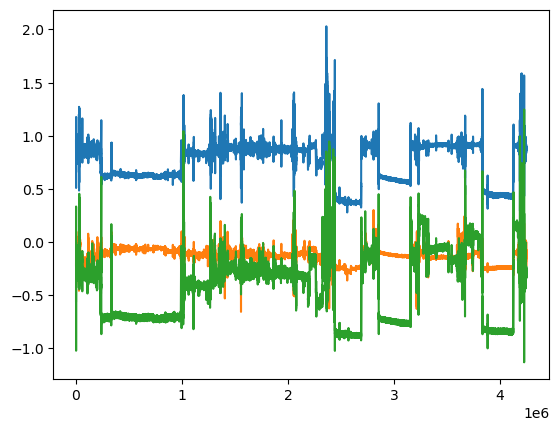

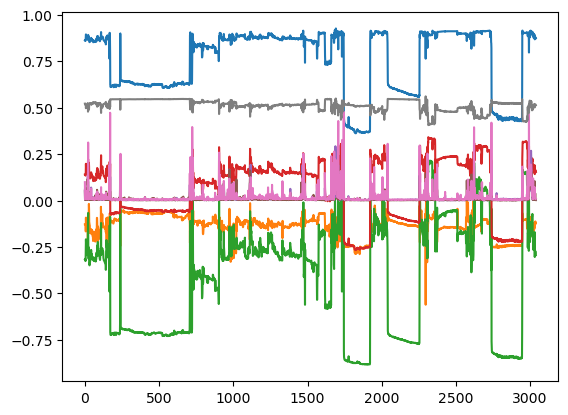

In [114]:

import numpy as np


# what do we want to end up with? arrays of each feature that are the same length as the labels(?)

def get_ACC_features(data):
    """
    Calculate the mean and standard deviation for each axis separately
    and summed across all axes.

    """

    axis0 = data[:,0]
    axis1 = data[:,1]
    axis2 = data[:,2]
    
    features = [np.mean(axis0), np.mean(axis1), np.mean(axis2), np.mean(data), np.std(axis0), np.std(axis1), np.std(axis2), np.std(data)]

    return features

def get_


acc_data = segmented_data["ACC"]
print(len(acc_data))

acc_features = np.zeros((len(acc_data),8))

#hello = get_ACC_features(segmented_data["ACC"][0])
#print(len(hello))

for i in range(len(acc_data)):
    #axis_means[i], axis_stds[i], total_mean[i], total_std[i] = get_ACC_features(segmented_data["ACC"][i])
    acc_features[i, :] = get_ACC_features(segmented_data["ACC"][i])

plt.plot(seg_labels)
plt.title(f"Segment labels for subject {subject_num}")
plt.xlabel("Segment")
plt.show()

plt.plot(chest_data["ACC"])
plt.show()

plt.plot(acc_features)
plt.show()

TODO re feature extraction
- calculate absolute integral of ACC data
- do frequency domain things

Other stuff lives down here in the graveyard

In [52]:
# if needed to download. but we already have the file saved so

import urllib.request

wesad_url = ("https://uni-siegen.sciebo.de/s/HGdUkoNlW1Ub0Gx/download")
filename = "wesad.zip"

urllib.request.urlretrieve(wesad_url, filename)


KeyboardInterrupt

